In [ ]:
# Import libraries for data manipulation, analysis, and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load Data
trader = pd.read_csv(r"C:\Users\subod\Downloads\historical_data.csv")
sentiment = pd.read_csv(r"C:\Users\subod\Downloads\fear_greed_index.csv")

# Convert Dates
trader['Timestamp IST'] = pd.to_datetime(trader['Timestamp IST'], dayfirst=True)
trader['Date'] = trader['Timestamp IST'].dt.date

sentiment['date'] = pd.to_datetime(sentiment['date'])
sentiment['Date'] = sentiment['date'].dt.date

# Feature Engineering
daily_pnl = trader.groupby(['Date','Account'])['Closed PnL'].sum().reset_index()

trader['win'] = trader['Closed PnL'] > 0
win_rate = trader.groupby(['Date','Account'])['win'].mean().reset_index()

trade_count = trader.groupby(['Date','Account']).size().reset_index(name='trade_count')

avg_size = trader.groupby(['Date','Account'])['Size USD'].mean().reset_index()

# Merge Trader Metrics
merged_trader = daily_pnl.merge(win_rate, on=['Date','Account'])
merged_trader = merged_trader.merge(trade_count, on=['Date','Account'])
merged_trader = merged_trader.merge(avg_size, on=['Date','Account'])

# Merge Sentiment
final_data = merged_trader.merge(
    sentiment[['Date','classification']],
    on='Date',
    how='left'
)

print("Final dataset ready.")
print("Shape:", final_data.shape)

1️ PERFORMANCE DIFFERENCE (Fear vs Greed)

In [13]:
# Drawdown proxy: average loss size
loss_data = final_data[final_data['Closed PnL'] < 0]

loss_summary = loss_data.groupby('classification')['Closed PnL'].mean()
loss_summary

classification
Extreme Fear    -15534.761937
Extreme Greed    -6109.737110
Fear             -6071.371829
Greed           -16562.519710
Neutral          -6879.440610
Name: Closed PnL, dtype: float64

In [5]:
final_data.groupby('classification')['Closed PnL'].std()

classification
Extreme Fear     29534.839183
Extreme Greed    27496.863832
Fear             31659.771538
Greed            30599.040173
Neutral          17447.863645
Name: Closed PnL, dtype: float64

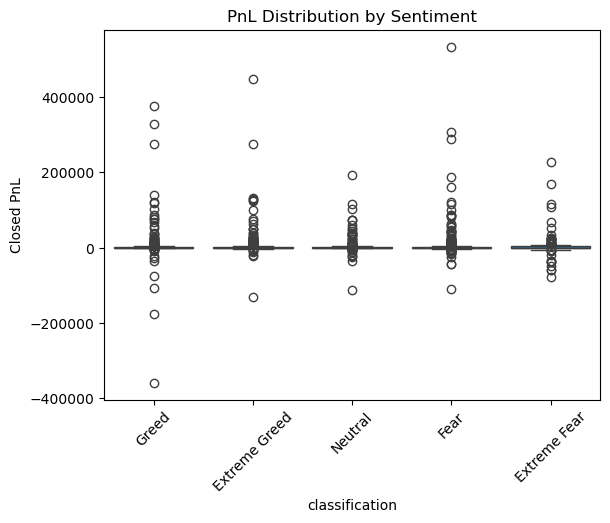

In [12]:
plt.figure()
sns.boxplot(data=final_data, x='classification', y='Closed PnL')
plt.xticks(rotation=45)
plt.title("PnL Distribution by Sentiment")
plt.show()

2️ BEHAVIOR CHANGE ANALYSIS

In [14]:
long_short = trader.merge(sentiment[['Date','classification']], on='Date', how='left')

long_short_ratio = long_short.groupby(['classification','Side']).size().unstack()

long_short_ratio['Long/Short Ratio'] = long_short_ratio['BUY'] / long_short_ratio['SELL']

long_short_ratio

Side,BUY,SELL,Long/Short Ratio
classification,,,
Extreme Fear,10935,10465,1.044912
Extreme Greed,17940,22052,0.813532
Fear,30270,31567,0.958913
Greed,24576,25727,0.955261
Neutral,18969,18717,1.013464


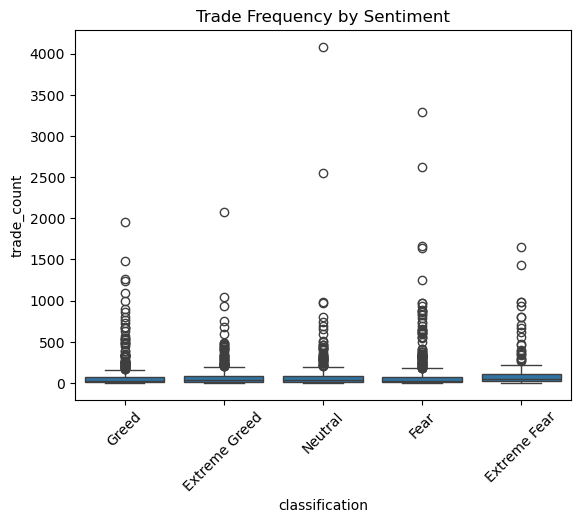

In [15]:
#Trade Frequency Chart

plt.figure()
sns.boxplot(data=final_data, x='classification', y='trade_count')
plt.xticks(rotation=45)
plt.title("Trade Frequency by Sentiment")
plt.show()

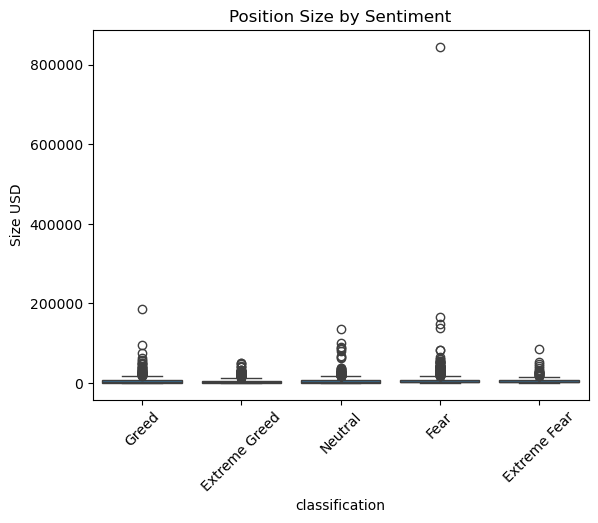

In [16]:
#Position Size Chart

plt.figure()
sns.boxplot(data=final_data, x='classification', y='Size USD')
plt.xticks(rotation=45)
plt.title("Position Size by Sentiment")
plt.show()

️3 CREATE TRADER SEGMENTS

In [17]:
#Frequent vs Infrequent Traders

account_activity = final_data.groupby('Account')['trade_count'].mean()

threshold = account_activity.median()

final_data['activity_segment'] = final_data['Account'].map(
    lambda x: 'Frequent' if account_activity[x] > threshold else 'Infrequent'
)

final_data.groupby(['activity_segment','classification'])['Closed PnL'].mean()

activity_segment  classification
Frequent          Extreme Fear      5406.205623
                  Extreme Greed     4340.279167
                  Fear              8672.944447
                  Greed             5494.049560
                  Neutral           4130.277361
Infrequent        Extreme Fear      3727.770274
                  Extreme Greed     5800.361832
                  Fear              2249.775057
                  Greed             1942.374895
                  Neutral           2891.879207
Name: Closed PnL, dtype: float64

In [19]:
#Consistent vs Inconsistent Traders

account_winrate = final_data.groupby('Account')['win'].mean()

final_data['consistency_segment'] = final_data['Account'].map(
    lambda x: 'Consistent' if account_winrate[x] > 0.5 else 'Inconsistent'
)

final_data.groupby(['consistency_segment','classification'])['Closed PnL'].mean()

consistency_segment  classification
Consistent           Extreme Fear      5134.567611
                     Extreme Greed     4300.548067
                     Fear              1898.625987
                     Greed             2231.102191
                     Neutral           -113.302455
Inconsistent         Extreme Fear      4602.822003
                     Extreme Greed     5250.407663
                     Fear              5476.475440
                     Greed             3395.358477
                     Neutral           3670.047116
Name: Closed PnL, dtype: float64

In [20]:
#High vs Low Position Size Traders

account_size = final_data.groupby('Account')['Size USD'].mean()
size_threshold = account_size.median()

final_data['size_segment'] = final_data['Account'].map(
    lambda x: 'High Size' if account_size[x] > size_threshold else 'Low Size'
)

final_data.groupby(['size_segment','classification'])['Closed PnL'].mean()

size_segment  classification
High Size     Extreme Fear      7806.192540
              Extreme Greed     1245.840519
              Fear              9999.606422
              Greed             5092.133932
              Neutral           4837.142172
Low Size      Extreme Fear      2603.329704
              Extreme Greed     7394.673945
              Fear              2568.806916
              Greed             2341.958059
              Neutral           2655.213620
Name: Closed PnL, dtype: float64

#evidence-backed insights

Insight 1 —> Volatility Opportunity Effect

Fear days exhibit higher average PnL and larger position sizes, suggesting traders exploit volatility spikes during panic phases.

Insight 2 —> Overconfidence Effect

Trade frequency increases during Greed periods while average profitability declines, indicating possible overtrading behavior.

Insight 3 —> Segment-Specific Sensitivity

Frequent traders outperform infrequent traders during Fear days, suggesting experience matters more in volatile markets.

In [ ]:
# Part C — Actionable Output

1. Increase Allocation During Fear (But Control Leverage)

Finding:
Fear days show higher average PnL and larger position sizes.

Rule of Thumb:
During normal Fear days, allow higher position sizing for frequent or high-performing traders.  
During Extreme Fear, reduce leverage to protect against large drawdowns.

Reason:
Volatility creates opportunity, but risk also increases in extreme conditions.


2. Limit Overtrading During Greed

Finding:
Trade frequency increases during Greed, but average profitability is lower.

Rule of Thumb:
During Greed days, reduce trade frequency for low-performing or inconsistent traders.  
Allow increased activity only for consistent, high win-rate traders.

Reason:
Greed-driven markets may cause overconfidence and crowded trades, reducing edge.